# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Overview

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, svm, metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration - Exploratory Data Analysis

## Portfolio Dataframe

In [2]:
# Statistics for the Portfolio Dataframe
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [3]:
# Portfolio Datatypes
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
# rows of the portfolio dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# Different Type of Channels
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [6]:
# Different types of offers
print("Different types of offers ------> ", portfolio['offer_type'].unique())

Different types of offers ------>  ['bogo' 'informational' 'discount']


### Profile Dataframe

In [7]:
# Statistics for the Profile Dataframe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
# DataTypes in the Profile Dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
# Checking the top 5  sample records of the Profile dataframe

profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# Checking the number of the age where is 118
df_profile_by_age = profile[profile['age'] == 118]

In [11]:
# Number of the members where age is missing 
print("Number of the members where age is missing -----> ", df_profile_by_age['age'].count())

Number of the members where age is missing ----->  2175


In [12]:
# Number of members where is gender is missing
print("Number of the members where gender is missing -----> ", (profile['gender'] == 'None').count())

Number of the members where gender is missing ----->  17000


In [13]:
# Number of members for which is income is missing in the dataset
print("Number of members for which is income is missing in the dataset-----> ", profile['income'].isnull().count())

Number of members for which is income is missing in the dataset----->  17000


In [14]:
# Number of the members which are having either income is zero and gender is missing
print("Number of the members which are having either income is zero and gender is missing ---> ",profile['income'].isnull().count() and profile['gender'].isnull().count())

Number of the members which are having either income is zero and gender is missing --->  17000


In [15]:
# Number of the duplicate records
profile.duplicated(subset = None, keep = 'first').count()

17000

In [16]:
# Quick view of the duplicate records in the profile dataset
profile.duplicated(subset = None, keep = 'first').head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [17]:
# Values having maximum, minimum and average income group
print("Maximum value in the income group --->", profile['income'].max())

Maximum value in the income group ---> 120000.0


In [18]:
# Values having maximum, minimum and average income group
print("Miminum value in the income group --->", profile['income'].min())

Miminum value in the income group ---> 30000.0


In [19]:
# Values having maximum, minimum and average income group
print("Mean value in the income group --->", profile['income'].mean())

Mean value in the income group ---> 65404.9915683


### Transcript Dataframe

In [20]:
# Statistics for the Transcript Dataframe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [21]:
# Viewing the top 5 records of the transcript dataframe

transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
# Checking the datatypes of the Transcript dataframe

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
# Checking the distinct events of the transcript

print("The distinct events of the transcript --->", transcript['event'].unique())

The distinct events of the transcript ---> ['offer received' 'offer viewed' 'transaction' 'offer completed']


In [24]:
# Number of the events in the transcript per category

print("Number of the events in the transcript  --->", transcript['event'].value_counts())

Number of the events in the transcript  ---> transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [25]:
# Number of null values in the transcript

print("Number of null values in the transcript  --->", (transcript['event'].isnull() == False).count())
print("Looks like there is no null values in the transcript dataframe")

Number of null values in the transcript  ---> 306534
Looks like there is no null values in the transcript dataframe


In [26]:
# Checking the records for the transcript event = 'transaction'

transcript[transcript.event=='transaction'].head(5)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


**Basic EDA conclusion and summary ----> In the first basic EDA of the 3 datasets, we have found that the Starbucks 3 offer type 'bogo', 'informational', 'discount', also number of the members which are having either income is zero and gender is missing is 17000 whereas profile dataframe has NaN values, mean value in the income group is ---> 65404.9915683**


### Data Visualization

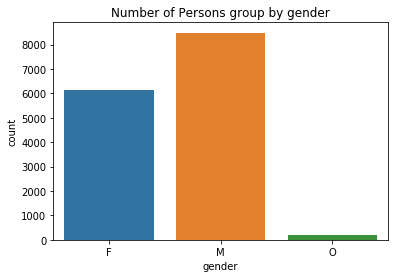

In [27]:
# Plotting the bar plot for the count of based on the gender

plt.title('Number of Persons group by gender')
sns.countplot(x='gender', data=profile)

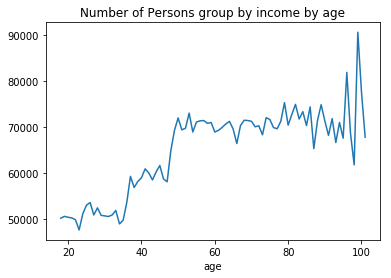

In [28]:
# Plotting the graphs based on the income group by age
plt.title('Number of Persons group by income by age')
profile.groupby(['age'])['income'].mean().plot(kind='line');

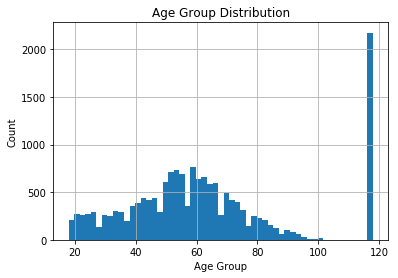

In [29]:
# Plotting the Age Group Distribution in the Histogram

profile.age.hist(bins = 55)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

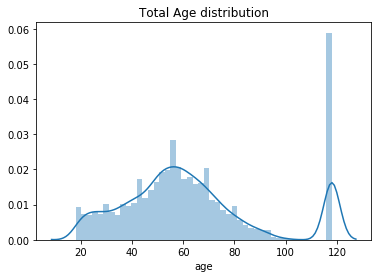

In [30]:
a = sns.distplot(profile['age']);
a.set_title('Total Age distribution');

**In the above three graphs, I have analysed the there are certain number of people which have not registered their with the Starbuck App which means they are considered to be outliners in the normal distribution curve.Hence, this needs to be fixed.**

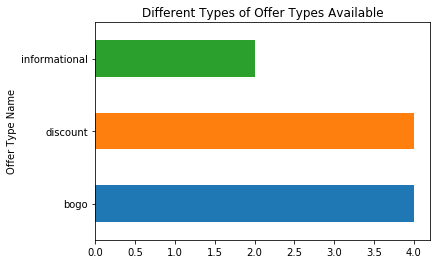

In [31]:
# Types of offer available 
a1 = portfolio.offer_type.value_counts()
a1.plot(kind='barh')
sns.set(style="darkgrid")
plt.ylabel('Offer Type Name')
plt.title('Different Types of Offer Types Available');

In [32]:
# Formatting the column 'became member on' so that we can use it for the further processing
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [33]:
# Top 5 records
profile['became_member_on'].head()

0   2017-02-12
1   2017-07-15
2   2018-07-12
3   2017-05-09
4   2017-08-04
Name: became_member_on, dtype: datetime64[ns]

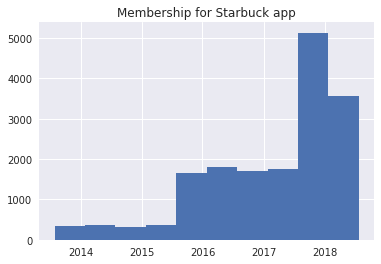

In [34]:
# Plotting the graph when customer becomes member of the Starbuck App
plt.title('Membership for Starbuck app')
profile['became_member_on'].hist()

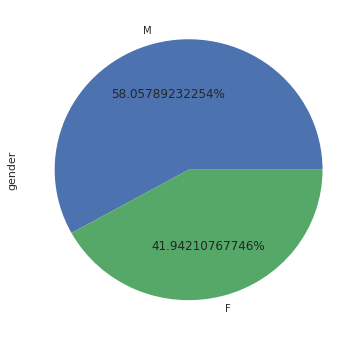

In [35]:
# Plotting the graph for the gender where unknown values are filtered out
df_piechart_for_gender = profile[profile['gender'] != 'O']
df_piechart_for_gender.gender.value_counts().plot(kind='pie' , figsize=(6, 6), autopct='%1.11f%%')

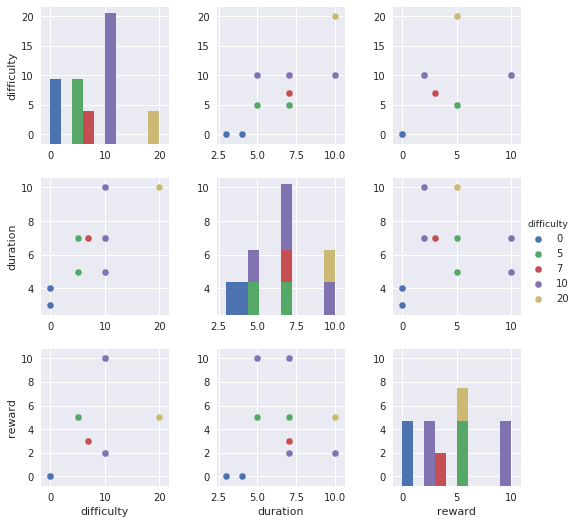

In [36]:
# PairPlot of the Portofolio Dataframe
sns.pairplot(portfolio,hue="difficulty", diag_kind="hist")

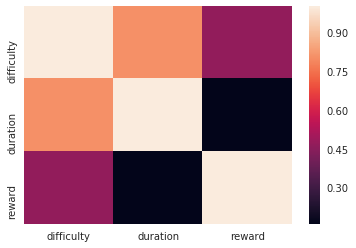

In [37]:
# Heatmaps for the Portfolio, transcript and profile
corr = portfolio.corr()
sns.heatmap(corr)

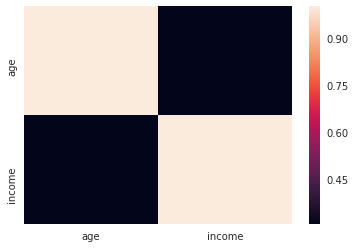

In [38]:
corr1 = profile.corr()
sns.heatmap(corr1)

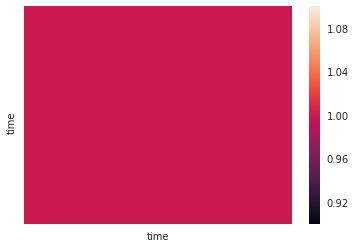

In [39]:
corr2 = transcript.corr()
sns.heatmap(corr2)

### Data Cleaning and Pre-Processing

## Cleaning Portfolio ##

**Handling Categorical Data in the Portfolio Dataframe**

In [40]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [41]:
# One hot encoding for the channels column using the MultiLabelBinarizer


portofolio_encoded = MultiLabelBinarizer().fit_transform(portfolio.channels)
portofolio_encoded

array([[1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 0, 1],
       [1, 0, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 1]])

In [42]:
df_portofolio_encoded = pd.DataFrame(portofolio_encoded, columns=['channel_email', 'channel_mobile', 'channel_social', 'channel_web'])

In [43]:
df_portofolio_encoded

,channel_email,channel_mobile,channel_social,channel_web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [44]:
# Concating the portfolio dataframe with the df_portofolio_encoded
portfolio1 = pd.concat([portfolio,df_portofolio_encoded], axis=0,sort=True)

In [45]:
df_portofolio_encoded_channel = portfolio.copy()

In [46]:
df_portofolio_encoded_dummy = pd.get_dummies(df_portofolio_encoded_channel.channels.apply(pd.Series).stack()).sum(level=0)
df_portofolio_encoded_channel = pd.concat([df_portofolio_encoded_channel, df_portofolio_encoded_dummy], axis=1)


In [47]:
df_portofolio_encoded_channel

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [48]:
# Assigning the different types of portfolio offers of the encoded channel to the numerical values 1,2,3
df_portofolio_encoded_channel.loc[(df_portofolio_encoded_channel.offer_type == 'bogo') , 'offer_type_number'] = 1
df_portofolio_encoded_channel.loc[(df_portofolio_encoded_channel.offer_type == 'discount') , 'offer_type_number'] = 2
df_portofolio_encoded_channel.loc[(df_portofolio_encoded_channel.offer_type == 'informational') , 'offer_type_number'] = 3


In [49]:
df_portofolio_encoded_channel

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,offer_type_number
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1.0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,3.0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1.0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,2.0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,2.0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,2.0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,3.0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1.0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,2.0


## Cleaning Profile ##

In [50]:
# Formatting the 'became member on' column in the Profile dataset

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [51]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


In [52]:
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [53]:
# Handling the none values of the gender and then replacing them to the others

# Replacing the Age value of the 118 with NaN 
profile.replace(118, np.nan , inplace=True)


In [54]:
# Filling the NaN values with the mean age of the column
profile['age'] = profile['age'].fillna(profile['age'].mean())

In [55]:
# Filling the NaN values for the income column with the mean average value

profile['income'] = profile['income'].fillna(profile['income'].mean())

In [56]:
# Removing the Outliners
 
profile = profile[profile['age'] <= 80]

In [57]:
# Adding Age Group column

profile.loc[(profile.age < 20) , 'Age_Group'] = 'Under 20'
profile.loc[(profile.age >= 20) & (profile.age <= 45) , 'Age_Group'] = '20-45'
profile.loc[(profile.age >= 46) & (profile.age <= 60) , 'Age_Group'] = '46-60'
profile.loc[(profile.age >= 61) , 'Age_Group'] = '61-80'

In [58]:
# Replacing missing gender values with mode which is the most frequent gender
gender_mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(gender_mode)

In [59]:
# Finally, the profile dataframe is cleaned with the income, gender, member and age group
profile.tail(10)

,age,became_member_on,gender,id,income,Age_Group
16989,54.393524,2018-03-05,M,ca45ee1883624304bac1e4c8a114f045,65404.991568,46-60
16990,70.000000,2016-03-10,F,79edb810789c447e8d212a324b44cc16,39000.000000,61-80
16991,54.393524,2016-01-16,M,a9a20fa8b5504360beb4e7c8712f8306,65404.991568,46-60
16992,21.000000,2017-09-17,F,400d0536e8794cbb855b0d882d67cbda,72000.000000,20-45
16993,60.000000,2018-05-05,M,cb23b66c56f64b109d673d5e56574529,113000.000000,46-60
16994,54.393524,2015-12-11,M,c02b10e8752c4d8e9b73f918558531f7,65404.991568,46-60
16995,45.000000,2018-06-04,F,6d5f3a774f3d4714ab0c092238f3a1d7,54000.000000,20-45
16996,61.000000,2018-07-13,M,2cb4f97358b841b9a9773a7aa05a9d77,72000.000000,61-80
16997,49.000000,2017-01-26,M,01d26f638c274aa0b965d24cefe3183f,73000.000000,46-60
16999,62.000000,2017-07-22,F,e4052622e5ba45a8b96b59aba68cf068,82000.000000,61-80


In [60]:
# Clubbing the ages into the age group brackets

profile.loc[(profile.Age_Group == 'Under 20') , 'age_group_number'] = 1
profile.loc[(profile.Age_Group == '20-45') , 'age_group_number'] = 2
profile.loc[(profile.Age_Group == '46-60') , 'age_group_number'] = 3
profile.loc[(profile.Age_Group == '61-80') , 'age_group_number'] = 4

In [61]:
profile.tail(10)

,age,became_member_on,gender,id,income,Age_Group,age_group_number
16989,54.393524,2018-03-05,M,ca45ee1883624304bac1e4c8a114f045,65404.991568,46-60,3.0
16990,70.000000,2016-03-10,F,79edb810789c447e8d212a324b44cc16,39000.000000,61-80,4.0
16991,54.393524,2016-01-16,M,a9a20fa8b5504360beb4e7c8712f8306,65404.991568,46-60,3.0
16992,21.000000,2017-09-17,F,400d0536e8794cbb855b0d882d67cbda,72000.000000,20-45,2.0
16993,60.000000,2018-05-05,M,cb23b66c56f64b109d673d5e56574529,113000.000000,46-60,3.0
16994,54.393524,2015-12-11,M,c02b10e8752c4d8e9b73f918558531f7,65404.991568,46-60,3.0
16995,45.000000,2018-06-04,F,6d5f3a774f3d4714ab0c092238f3a1d7,54000.000000,20-45,2.0
16996,61.000000,2018-07-13,M,2cb4f97358b841b9a9773a7aa05a9d77,72000.000000,61-80,4.0
16997,49.000000,2017-01-26,M,01d26f638c274aa0b965d24cefe3183f,73000.000000,46-60,3.0
16999,62.000000,2017-07-22,F,e4052622e5ba45a8b96b59aba68cf068,82000.000000,61-80,4.0


In [62]:
# Clubbing the income into the average-1, above average-2, more than average - 3
profile.loc[(profile.income >= 30000) & (profile.income <= 60000) , 'income_group_number'] = 1
profile.loc[(profile.income >= 600001) & (profile.income <= 90000) , 'income_group_number'] = 2
profile.loc[(profile.income > 90000) , 'income_group_number'] = 3

In [63]:
# Bracketing the gender Male - 1, Female-2 

profile.loc[(profile.gender == 'M') , 'gender_group_number'] = 1
profile.loc[(profile.gender == 'F') , 'gender_group_number'] = 2


## Cleaning Transcript ##

**Rename column person to cutsomer_id for better readability**

In [64]:
transcript = transcript.rename(columns={'person': 'customer_id'})

In [65]:
transcript.head(10)

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [66]:
# Calculating the cross tab for the transcript dataframe for the column 'value'
keys = transcript['value'].apply(lambda y: str(list(y.keys())))



In [67]:
# Printing the cross tab values of the transcript 'event' column

pd.crosstab(keys, transcript['event'])

event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


In [68]:
#  Concating the transcript and the encoded transcript dataframe

transcript_encoded = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, transcript_encoded], axis=1 )

In [69]:
transcript.head(5)

,event,customer_id,time,value,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [70]:
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount_spent'] = [np.round([*i.values()][0], decimals=3)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

In [71]:
transcript.head(5)

,event,customer_id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [72]:
transcript['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

In [73]:
df_portofolio_encoded_channel = df_portofolio_encoded_channel.rename(columns={'id': 'offer_id'})

In [74]:
# Merging the dataframe - Portfolio and Transcript on the offer_id
df_merged_portfolio_transcript = pd.merge(df_portofolio_encoded_channel, transcript, on='offer_id')

In [75]:
# Checking the datatypes of the portofolio encoded dataframe

df_portofolio_encoded_channel.dtypes

channels              object
difficulty             int64
duration               int64
offer_id              object
offer_type            object
reward                 int64
email                  uint8
mobile                 uint8
social                 uint8
web                    uint8
offer_type_number    float64
dtype: object

In [76]:
df_merged_portfolio_transcript.head(5)

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,offer_type_number,event,customer_id,time,value,offer completed,offer received,offer viewed,transaction,amount_spent
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0,offer received,1e9420836d554513ab90eba98552d0a9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0,offer received,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0,offer received,676506bad68e4161b9bbaffeb039626b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.0,offer received,fe8264108d5b4f198453bbb1fa7ca6c9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN


In [77]:
# Renaming the id column in the profile dataframe to the customer id 

df_profile = profile.rename(columns={'id': 'customer_id'})

In [78]:
df_profile.dtypes

age                           float64
became_member_on       datetime64[ns]
gender                         object
customer_id                    object
income                        float64
Age_Group                      object
age_group_number              float64
income_group_number           float64
gender_group_number           float64
dtype: object

In [79]:
df_merged_portfolio_transcript.dtypes

channels              object
difficulty             int64
duration               int64
offer_id              object
offer_type            object
reward                 int64
email                  uint8
mobile                 uint8
social                 uint8
web                    uint8
offer_type_number    float64
event                 object
customer_id           object
time                   int64
value                 object
offer completed        uint8
offer received         uint8
offer viewed           uint8
transaction            uint8
amount_spent         float64
dtype: object

In [80]:
# Merging the dataframe - Portfolio, Transcript and Profile 

df_merged_portfolio_transcript_profile = pd.merge(df_merged_portfolio_transcript, df_profile, on='customer_id')

In [81]:
df_merged_portfolio_transcript_profile.head(6)

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,...,transaction,amount_spent,age,became_member_on,gender,income,Age_Group,age_group_number,income_group_number,gender_group_number
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,...,0,NaN,64.0,2017-09-09,M,100000.0,61-80,4.0,3.0,1.0


In [82]:
# Checking the data types of the portfolio transcript dataframe

df_merged_portfolio_transcript_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 28 columns):
channels               157503 non-null object
difficulty             157503 non-null int64
duration               157503 non-null int64
offer_id               157503 non-null object
offer_type             157503 non-null object
reward                 157503 non-null int64
email                  157503 non-null uint8
mobile                 157503 non-null uint8
social                 157503 non-null uint8
web                    157503 non-null uint8
offer_type_number      157503 non-null float64
event                  157503 non-null object
customer_id            157503 non-null object
time                   157503 non-null int64
value                  157503 non-null object
offer completed        157503 non-null uint8
offer received         157503 non-null uint8
offer viewed           157503 non-null uint8
transaction            157503 non-null uint8
amount_spent           0 n

In [83]:
# Cuttting down the columns to make the ML prediction 

df_merged_predict = df_merged_portfolio_transcript_profile.copy()
                                                    

In [84]:
# Dropping the extra columns from the merged data frame

df_merged_predict_clean = df_merged_predict.drop(['offer_id','channels','offer_type','customer_id','gender','Age_Group','value','amount_spent'],axis=1)

In [85]:

#df_merged_predict_clean['amount_spent'] = df_merged_predict_clean['amount_spent'].fillna(df_merged_predict_clean['amount_spent'].mean())

In [86]:
df_merged_predict_clean.tail(10)

,difficulty,duration,reward,email,mobile,social,web,offer_type_number,event,time,offer completed,offer received,offer viewed,transaction,age,became_member_on,income,age_group_number,income_group_number,gender_group_number
157493,10,7,2,1,1,0,1,2.0,offer received,576,0,1,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157494,10,7,2,1,1,0,1,2.0,offer viewed,630,0,0,1,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157495,10,7,2,1,1,0,1,2.0,offer completed,642,1,0,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157496,10,7,2,1,1,0,1,2.0,offer received,408,0,1,0,0,70.000000,2016-11-02,79000.000000,4.0,NaN,2.0
157497,10,7,2,1,1,0,1,2.0,offer received,576,0,1,0,0,70.000000,2016-11-02,79000.000000,4.0,NaN,2.0
157498,10,7,2,1,1,0,1,2.0,offer received,504,0,1,0,0,31.000000,2017-07-04,45000.000000,2.0,1.0,1.0
157499,10,7,2,1,1,0,1,2.0,offer viewed,504,0,0,1,0,31.000000,2017-07-04,45000.000000,2.0,1.0,1.0
157500,10,7,2,1,1,0,1,2.0,offer completed,630,1,0,0,0,31.000000,2017-07-04,45000.000000,2.0,1.0,1.0
157501,10,7,2,1,1,0,1,2.0,offer received,576,0,1,0,0,59.000000,2017-08-20,44000.000000,3.0,1.0,1.0
157502,10,7,2,1,1,0,1,2.0,offer completed,630,1,0,0,0,59.000000,2017-08-20,44000.000000,3.0,1.0,1.0


In [87]:
# Converting the offer completed,offer viewed, offer received to the numerical values so that 
# it can be used for the ML prediction

df_merged_predict_clean.loc[(df_merged_predict_clean.event == 'offer completed') , 'event'] = 1
df_merged_predict_clean.loc[(df_merged_predict_clean.event == 'offer viewed') , 'event'] = 2
df_merged_predict_clean.loc[(df_merged_predict_clean.event == 'offer received') , 'event'] = 3

In [88]:
df_merged_predict_clean.tail(15)

,difficulty,duration,reward,email,mobile,social,web,offer_type_number,event,time,offer completed,offer received,offer viewed,transaction,age,became_member_on,income,age_group_number,income_group_number,gender_group_number
157488,10,7,2,1,1,0,1,2.0,2,426,0,0,1,0,54.393524,2017-07-28,65404.991568,3.0,NaN,1.0
157489,10,7,2,1,1,0,1,2.0,3,576,0,1,0,0,54.393524,2017-07-28,65404.991568,3.0,NaN,1.0
157490,10,7,2,1,1,0,1,2.0,3,408,0,1,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157491,10,7,2,1,1,0,1,2.0,2,408,0,0,1,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157492,10,7,2,1,1,0,1,2.0,1,540,1,0,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157493,10,7,2,1,1,0,1,2.0,3,576,0,1,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157494,10,7,2,1,1,0,1,2.0,2,630,0,0,1,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157495,10,7,2,1,1,0,1,2.0,1,642,1,0,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157496,10,7,2,1,1,0,1,2.0,3,408,0,1,0,0,70.000000,2016-11-02,79000.000000,4.0,NaN,2.0
157497,10,7,2,1,1,0,1,2.0,3,576,0,1,0,0,70.000000,2016-11-02,79000.000000,4.0,NaN,2.0


In [89]:
# Filtering the rows only for 'offer completed' or 'offer viewed'
df_merged_predict_clean = df_merged_predict_clean[df_merged_predict_clean.event != 3] 

In [90]:
df_merged_predict_clean.tail(10)

,difficulty,duration,reward,email,mobile,social,web,offer_type_number,event,time,offer completed,offer received,offer viewed,transaction,age,became_member_on,income,age_group_number,income_group_number,gender_group_number
157484,10,7,2,1,1,0,1,2.0,2,456,0,0,1,0,66.000000,2018-07-16,56000.000000,4.0,1.0,1.0
157486,10,7,2,1,1,0,1,2.0,2,438,0,0,1,0,54.393524,2017-01-15,65404.991568,3.0,NaN,1.0
157488,10,7,2,1,1,0,1,2.0,2,426,0,0,1,0,54.393524,2017-07-28,65404.991568,3.0,NaN,1.0
157491,10,7,2,1,1,0,1,2.0,2,408,0,0,1,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157492,10,7,2,1,1,0,1,2.0,1,540,1,0,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157494,10,7,2,1,1,0,1,2.0,2,630,0,0,1,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157495,10,7,2,1,1,0,1,2.0,1,642,1,0,0,0,54.393524,2017-03-23,65404.991568,3.0,NaN,1.0
157499,10,7,2,1,1,0,1,2.0,2,504,0,0,1,0,31.000000,2017-07-04,45000.000000,2.0,1.0,1.0
157500,10,7,2,1,1,0,1,2.0,1,630,1,0,0,0,31.000000,2017-07-04,45000.000000,2.0,1.0,1.0
157502,10,7,2,1,1,0,1,2.0,1,630,1,0,0,0,59.000000,2017-08-20,44000.000000,3.0,1.0,1.0


In [91]:
# Filling the NaN values for the income and gender group with the average mean values

df_merged_predict_clean['income_group_number'] = df_merged_predict_clean['income_group_number'].fillna(df_merged_predict_clean['income_group_number'].mean())
df_merged_predict_clean['gender_group_number'] = df_merged_predict_clean['gender_group_number'].fillna(df_merged_predict_clean['gender_group_number'].mean())

In [92]:
# Converting the float data types of the few columns to the integer datatype before making ML prediction
df_merged_predict_clean["offer_type_number"] = df_merged_predict_clean["offer_type_number"].astype(int)
df_merged_predict_clean["age_group_number"] = df_merged_predict_clean["age_group_number"].astype(int)
df_merged_predict_clean["income_group_number"] = df_merged_predict_clean["income_group_number"].astype(int)
df_merged_predict_clean["gender_group_number"] = df_merged_predict_clean["gender_group_number"].astype(int)

In [93]:
# Assigining the X and Y variables before ML prediction

X = df_merged_predict_clean[['time','difficulty','duration','reward','offer_type_number','age_group_number','income_group_number','gender_group_number']]
Y = df_merged_predict_clean['event']

In [94]:
# Top 5 records of the X variable
X.head()

,time,difficulty,duration,reward,offer_type_number,age_group_number,income_group_number,gender_group_number
1,102,10,7,10,1,4,3,1
3,510,10,7,10,1,4,3,1
4,510,10,7,10,1,4,3,1
6,468,0,4,0,3,4,3,1
8,174,20,10,5,2,4,3,1


In [95]:
# DataTypes of the X variable
X.dtypes

time                   int64
difficulty             int64
duration               int64
reward                 int64
offer_type_number      int64
age_group_number       int64
income_group_number    int64
gender_group_number    int64
dtype: object

In [96]:
# Top 5 records of the Y variable
Y.head()

1    2
3    2
4    1
6    2
8    2
Name: event, dtype: int64

In [97]:
# Splitting the data into the test and train based on 33% test size

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
# Create linear regression object
linear_regression = LinearRegression()

In [99]:
# Fitting the Linear Regression model on the training data

linear_regression.fit(X_train, y_train)
print('Accuracy of Linear Regression classifier on training set: {:.2f}'
     .format(linear_regression.score(X_train, y_train)))
print('Accuracy of Linear Regression classifier on test set: {:.2f}'
     .format(linear_regression.score(X_test, y_test)))

Accuracy of Linear Regression classifier on training set: 0.11
Accuracy of Linear Regression classifier on test set: 0.11


In [100]:
#Using the random forest classifier for the prediction

classifier=RandomForestClassifier()
classifier=classifier.fit(X_train,y_train)
predicted=classifier.predict(X_test)
 
#printing the results
print ('Confusion Matrix :')
print(confusion_matrix(y_test, predicted))
print ('Accuracy Score :',accuracy_score(y_test, predicted))
print ('Report : ')
print (classification_report(y_test, predicted))

Confusion Matrix :
[[ 4827  5507]
 [ 3495 14433]]
Accuracy Score : 0.68148043309
Report : 
             precision    recall  f1-score   support

          1       0.58      0.47      0.52     10334
          2       0.72      0.81      0.76     17928

avg / total       0.67      0.68      0.67     28262



In [101]:
# Logistic Regression of our ML model

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.65
Accuracy of Logistic regression classifier on test set: 0.65


In [102]:
# DecisionTreeClassifier of our ML model

clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.77
Accuracy of Decision Tree classifier on test set: 0.69


In [103]:
# KNN Classifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.73
Accuracy of K-NN classifier on test set: 0.67


In [104]:
# SVC

from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.65
Accuracy of SVM classifier on test set: 0.65


In [105]:
# Model Refinement using Grid Search Cross Valiation - Hyperparameters Tuning
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train, y_train)

print("Hypertune Parameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


Hypertune Parameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.654815434487


In [106]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_test,y_test))

score 0.651758545043
